## Метрики классификации

В этом ноутбуке рассматриваются базовые метрики качества бинарной классификации:
accuracy, precision, recall и F1-score.

Метрики сначала вычисляются вручную на основе матрицы ошибок,
после чего результаты сравниваются с реализациями из библиотеки `sklearn`.
Цель — понять, как именно формируются значения метрик и чем они отличаются
с точки зрения интерпретации.


In [1]:
import numpy as np
from typing import Tuple
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from typing import Dict, Tuple
import matplotlib.pyplot as plt


In [2]:

def solution_ms(TN, FP, FN, TP) -> Dict[str, np.ndarray]:
    

    """
    Accuracy показывает долю правильных предсказаний от общего числа наблюдений.

    Метрика хорошо работает при сбалансированных классах,
    но может вводить в заблуждение при сильном дисбалансе,
    когда модель угадывает только доминирующий класс.
    """
    try:
        accuracy = (TP + TN) / (TP + TN + FP + FN)
    except:
        raise ZeroDivisionError

    """
    Precision показывает, какая доля объектов,
    предсказанных как положительный класс,
    действительно относится к этому классу.

    Метрика важна в задачах, где цена ложноположительного решения высока
    """
    try:
        precision = TP / (TP + FP)
    except:
        raise ZeroDivisionError

    """
    Recall показывает, какую долю положительных объектов
    модель смогла корректно обнаружить.

    Метрика особенно важна в задачах,
    где пропуск положительного случая критичен.
    """
    try:
        recall = TP / (TP + FN)
    except:
        raise ZeroDivisionError
    
    """
    F1-score является гармоническим средним между precision и recall
    и используется как компромиссная метрика,
    когда важно учитывать оба типа ошибок одновременно.
    """
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except:
        raise ZeroDivisionError


    return {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1 score": float(f1),
    }
 

### Подготовка данных

Для иллюстрации работы метрик используется синтетический пример бинарной классификации.
Такой подход позволяет контролировать количество ошибок и наглядно проследить,
как они влияют на значения метрик.

В примере далее предполагается дисбаланс классов,
что типично для реальных задач (антифрод, медицина, рекомендации).


In [3]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_classes=2,
    weights=[0.90, 0.10],
    random_state=42
)

# Разделим данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Создаем можель логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Предсказываем значения
y_pred = model.predict(X_test)

threshold = 0.5

### Матрица ошибок (Confusion Matrix)

Матрица ошибок показывает количество:
- истинно положительных (TP),
- ложноположительных (FP),
- ложноотрицательных (FN),
- истинно отрицательных (TN) предсказаний.

Все основные метрики классификации напрямую выводятся из этих четырёх величин.


In [4]:
def confusion_matrix_c(y_true: np.ndarray, y_pred: np.ndarray, threshold: float) -> Tuple[int, int, int, int]:
    """Calculate confusion matrix."""
    y_pred_bin = y_pred >= threshold
    TP = np.sum((y_pred_bin == 1) & (y_true == 1))
    FP = np.sum((y_pred_bin == 1) & (y_true == 0))
    FN = np.sum((y_pred_bin == 0) & (y_true == 1))
    TN = np.sum((y_pred_bin == 0) & (y_true == 0))

    return TP, TN, FP, FN

In [5]:
TP, TN, FP, FN = confusion_matrix_c(y_test, y_pred, threshold)
cm = np.array([[TN, FP], [FN, TP]])

#### Heatmap матрицы ошибок

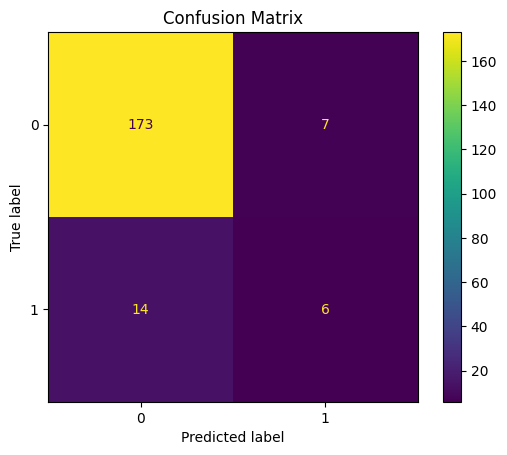

In [6]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [7]:
metrics_res = solution_ms(TN, FP, FN, TP)

In [8]:
print(f'Метрики, реализованные вручную:\n'
      f'{metrics_res}')

Метрики, реализованные вручную:
{'accuracy': 0.895, 'precision': 0.46153846153846156, 'recall': 0.3, 'f1 score': 0.3636363636363637}


### Сравнение с реализациями sklearn

Результаты ручного расчёта метрик сравниваются
с реализациями из библиотеки `sklearn`,
что позволяет проверить корректность вычислений.


In [9]:
# Расчет тех же метрик с помощью sklearn
accuracy_sk = accuracy_score(y_test, y_pred)
precision_sk = precision_score(y_test, y_pred)
recall_sk = recall_score(y_test, y_pred)
f1_sk = f1_score(y_test, y_pred)

metrics_sk = {
    "accuracy": accuracy_sk,
    "precision": precision_sk,
    "recall": recall_sk,
    "f1 score": f1_sk,
}

In [10]:
print(f'Метрики, реализованные в sklearn:\n'
      f'{metrics_sk}')

Метрики, реализованные в sklearn:
{'accuracy': 0.895, 'precision': 0.46153846153846156, 'recall': 0.3, 'f1 score': 0.36363636363636365}


### Зависимость метрик от порога классификации

При использовании вероятностных предсказаний значение порога (`threshold`)
напрямую влияет на соотношение ошибок первого и второго рода.

Увеличение порога, как правило, повышает precision,
но снижает recall, и наоборот.
F1-score отражает компромисс между этими двумя метриками.


In [11]:
# вероятности положительного класса
y_score = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# F1 считаем на этих же точках
f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)

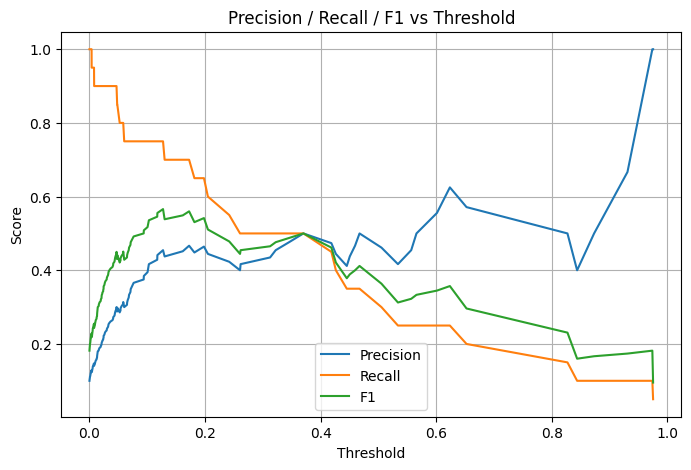

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1, label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

На графике видно, что precision и recall изменяются в противоположных направлениях,
в то время как F1-score достигает максимума в точке,
где достигается баланс между ними.


## Выводы

- Все основные метрики классификации напрямую выводятся из матрицы ошибок
  и отражают разные аспекты качества модели.
- Accuracy может быть вводящей в заблуждение метрикой при дисбалансе классов,
  так как не учитывает структуру ошибок.
- Precision и recall отражают разные типы рисков и находятся в компромиссном соотношении,
  зависящем от выбранного порога классификации.
- F1-score позволяет найти баланс между precision и recall,
  что делает её удобной метрикой для подбора порога в задачах,
  где важно учитывать оба типа ошибок.

Выбор метрики должен определяться требованиями конкретной задачи,
а не универсальным правилом.
